# Raytracing

In this sixth and final lab of the ErSE 210 - Seismology course, we will learn how to code the Normal Moveout (NMO) correction algorithm.

Let's start by recalling the equation that can be used to model seismic data in the common midpoint gather (CMP) domain:    
$$
t = \sqrt{t_0^2 + \frac{x^2}{v_{rms}^2}}
$$

where $t_0$ is the zero-offset traveltime, $x$ is the half offset and $v_{rms}$ is the root-mean-square velocity.

The notebook is organized as follow:

- Create a synthetic CMP dataset
- Compute the semblance panel
- Perform NMO correction

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as filt

from pylops.utils.wavelets import ricker

## CMP modelling

Let's start writing a function that can model a CMP gather. We do this as follows:

- Define a number of events parametrized by the triplet $(t_0, v_{rms}, A)$
- Compute the associated traveltime curves
- Places A values along the traveltime curves in a 2d panel of size $(n_t, n_x)$
- Convolve with wavelet
- Add noise (optional)

In [2]:
def cmpmodelling(x, t, t0, vrms, amp, wav, sigma=0):
    """CMP Modelling
    
    Parameters
    ----------
    x : np.ndarray
        Spatial axis 
    t : np.ndarray
        Time axis
    t0 : np.ndarray
        Zero-offset time of events
    vrms : np.ndarray
        Root-mean-square velocity of events
    amp : np.ndarray
        Amplitude of events
    wav : np.ndarray
        Wavelet
    sigma : float, optional
        Noise standard deviation
    
    Returns
    -------
    d : np.ndarray
        Data (nt x nx)

    """
    # identify sampling and dimensions
    wcenter = np.argmax(wav)
    dt = t[1]-t[0]
    nx = len(x)
    nt = len(t) + wcenter
    nevents = len(t0)

    # create events
    d = np.zeros((nx, nt))
    for ievent in range(nevents):
        tevent = np.sqrt(t0[ievent] ** 2 + x ** 2 / vrms[ievent] ** 2)
        tevent = (tevent - t[0]) / dt
        itevent = tevent.astype(int)
        dtevent = tevent - itevent
        for ix in range(nx):
            if itevent[ix] < nt - 1 and itevent[ix] >= 0:
                # linear interpolation
                d[ix, itevent[ix]] += amp[ievent] * (1 - dtevent[ix])
                d[ix, itevent[ix] + 1] += amp[ievent] * dtevent[ix]

    # convolve with wavelet
    dwav = filt.lfilter(wav, 1, d, axis=-1)
    dwav = dwav[..., wcenter:]
    
    # add noise
    if sigma > 0:
        dwav += sigma * np.random.normal(0., 1., (nx, nt - wcenter))
    return dwav.T

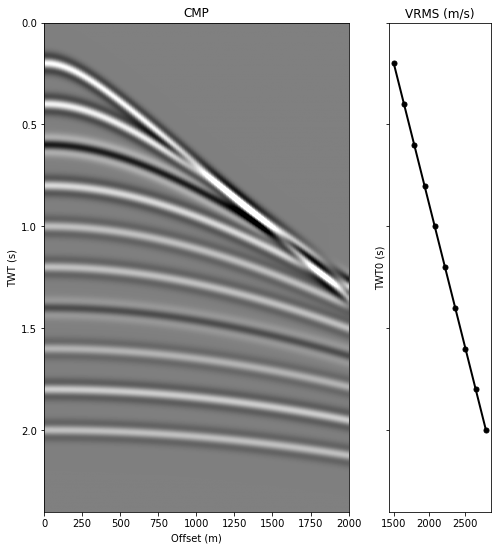

In [3]:
ot, dt, nt = 0, 0.004, 601
ox, dx, nx = 0, 10, 201
f0 = 10
nevents = 10
t0 = np.linspace(0.2, 2, nevents)
vrms = np.linspace(1500, 2800, nevents)
amp = [1, 0.9, -0.8, 0.7, 0.5, 0.5, -0.4, 0.4, 0.6, 0.5]
sigma = 0.

t = np.arange(nt) * dt + ot
x = np.arange(nx) * dx + ox
wav = ricker(t[:101], f0)[0]

d0 = cmpmodelling(x, t, t0, vrms, amp, wav)
d = cmpmodelling(x, t, t0, vrms, amp, wav, sigma)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 9), gridspec_kw={'width_ratios': [3, 1]})
axs[0].imshow(d, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('CMP')
axs[0].axis('tight')
axs[1].plot(vrms, t0, '.-k', ms=10, lw=2)
axs[1].set_ylabel('TWT0 (s)')
axs[1].set_title('VRMS (m/s)')
axs[1].axis('tight');

## Semblance Stack

We are now ready to compute the semblance stack which can be used to estimate a $v_rms(t_0)$ profile directly from a CMP gather. In this case we know the velocity profile so we can use this to check our semblance implementation is good.

To compute the semblance we proceed as follows:

- Define ranges for $t_0$ and $v_{rms}$ which we want to test on the data
- For each $(t_0, v_{rms})$ pair, compute the traveltime curve as stack the data using the following relation
$$
S(t_0, v_{rms}) = \frac{\sum{d(t(x; t_0, v_{rms}), x)})^2}{N\sum{d(t(x; t_0, v_{rms}), x)}}
$$
where N is the number of traces involved in the summation
- Apply a time-dependant smoothing

In [4]:
def semblance(d, x, t, t0, vrms, nsmooth=5):
    """Semblance Stack
    
    Parameters
    ----------
    d : np.ndarray
        Data (nt x nx)
    x : np.ndarray
        Spatial axis
    t : np.ndarray
        Time axis
    t0 : np.ndarray
        Zero-offset time axis
    vrms : np.ndarray
        Root-mean-square velocity axis
    nsmooth : int, optional
        Length of smoothing filter
    
    Returns
    -------
    ss : np.ndarray
        Semblance stack (nt0 x nvrms)

    """
    # identify sampling and dimensions
    dt = t[1]-t[0]
    nx = x.size
    nt = t.size
    nvrms = vrms.size
    nt0 = t0.size
    
    # compute semblance
    ix = np.arange(nx)
    num = np.zeros((nt0, nvrms))
    den = np.zeros((nt0, nvrms))
    nn = np.zeros((nt0, nvrms))
    for it0, t0_ in enumerate(t0):
        for ivrms, vrms_ in enumerate(vrms):
            tevent = np.sqrt(t0_ ** 2 + x ** 2 / vrms_ ** 2)
            tevent = (tevent - t[0]) / dt
            itevent = tevent.astype(int)
            dtevent = tevent - itevent
            mask = (itevent < nt - 1) & (itevent >= 0)
            dss = d[itevent[mask], ix[mask]] * (1 - dtevent[mask]) + d[itevent[mask], ix[mask]] * dtevent[mask]
            num[it0, ivrms] = np.sum(dss)**2
            den[it0, ivrms] = np.sum(dss**2)
            nn[it0, ivrms] = len(dss)
    ss = num / (nn * den + 1e-10)
    
    # smooth along time axis
    ss = filt.filtfilt(np.ones(nsmooth) / nsmooth, 1, ss.T).T
    return ss

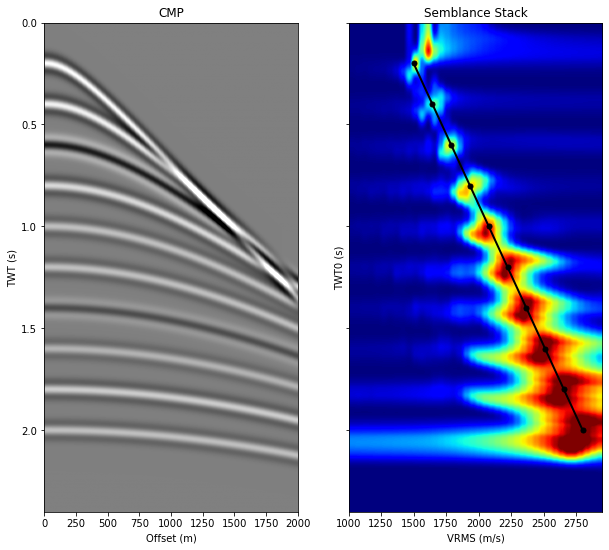

In [5]:
t0axis = t.copy()
vrmsaxis = np.arange(1000, 3000, 50)
clip = 0.9

ss = semblance(d, x, t, t0axis, vrmsaxis, nsmooth=15)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 9))
axs[0].imshow(d, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('CMP')
axs[0].axis('tight')
axs[1].imshow(ss, cmap='jet', vmin=0, vmax=clip*ss.max(),
              extent=(vrmsaxis[0], vrmsaxis[-1], t0axis[-1], t0axis[0]))
axs[1].plot(vrms, t0, '.-k', ms=10, lw=2)
axs[1].set_xlabel('VRMS (m/s)')
axs[1].set_ylabel('TWT0 (s)')
axs[1].set_title('Semblance Stack')
axs[1].axis('tight');

## NMO Correction

Let's first apply NMO correction without applying any mask. What we observe here is known as **NMO streching**. We can then apply a linear mask to remove this before stacking the available traces

NMO correction can be accomplished in the following steps:
- Define a $v_{rms}(t_0)$ profile you wish to correct the data for
- For each $(t_0, v_{rms})$ pair, compute the traveltime curve and move the values of the seismic data from position $(t, x)$ to  $(t_0, x)$
- Apply muting to counteract NMO streching.

In [6]:
def nmocorrection(d, x, t0, vrms, vmask=None):
    """Semblance Stack
    
    Parameters
    ----------
    d : np.ndarray
        Data (nt x nx)
    x : np.ndarray
        Spatial axis
    t0 : np.ndarray
        Zero-offset time axis
    vrms : np.ndarray
        Root-mean-square velocity axis
    vmask : int, optional
        Velocity of linear event used as mask
    
    Returns
    -------
    dnmo : np.ndarray
        NMO corrected data stack (nt x nx)

    """
    # identify sampling and dimensions
    dt = t0[1]-t0[0]
    nx = x.size
    nvrms = vrms.size
    nt0 = t0.size
    
    # flatten events
    ix = np.arange(nx)
    dnmo = np.zeros((nt0, nx))
    for it0, t0_ in enumerate(t0):
        tevent = np.sqrt(t0_ ** 2 + x ** 2 / vrms[it0] ** 2)
        tevent = (tevent - t[0]) / dt
        itevent = tevent.astype(int)
        dtevent = tevent - itevent
        mask = (itevent < nt - 1) & (itevent >= 0)
        nmask = np.sum(mask)
        dnmo[it0 * np.ones(nmask, dtype='int'), ix[mask]] += \
            d[itevent[mask], ix[mask]] * (1 - dtevent[mask]) + d[itevent[mask], ix[mask]] * dtevent[mask]
    
    # apply mask
    mask = np.ones((nt0, nx))
    if vmask:
        tmask = x / vmask
        itmask = (tmask / dt).astype(int)
        for ix in range(nx):
            mask[:itmask[ix], ix] = 0.
        dnmo *= mask
    fold = np.sum(mask, axis=1)
    return dnmo, fold

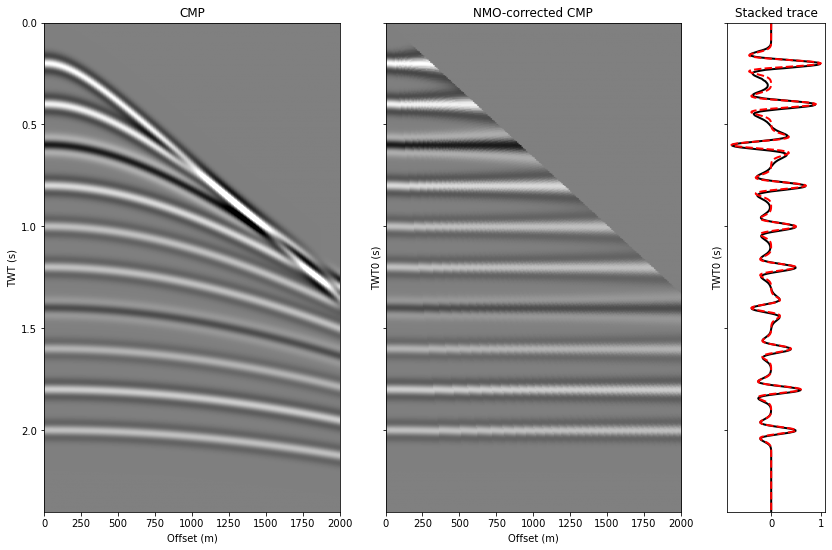

In [7]:
vrmsnmo = np.interp(t0axis, t0, vrms)
dnmo, fold = nmocorrection(d, x, t0axis, vrmsnmo, vmask=1500)

# stack
dstack = np.sum(dnmo, axis=-1) / fold

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9), gridspec_kw={'width_ratios': [3, 3, 1]})
axs[0].imshow(d, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('CMP')
axs[0].axis('tight')
axs[1].imshow(dnmo, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT0 (s)')
axs[1].set_title('NMO-corrected CMP')
axs[1].axis('tight')
axs[2].plot(dstack, t0axis, 'k', ms=10, lw=2)
axs[2].plot(d0[:, 0], t0axis, '--r', ms=10, lw=2)
axs[2].set_ylabel('TWT0 (s)')
axs[2].set_title('Stacked trace')
axs[2].axis('tight');

### Exercises:

- Investigate NMO Streching. Write half a page describing why it occurs during NMO correction (there is plently of literature online on the topic, or you can consult the Yilmaz book)
- Repeat the same flow for different levels of noise. Parametrize this as function of SNR and show the gain in SNR obtained by NMO stacking
- Apply the NMO correction flow to a CMP gather of the Volve dataset. Ultimately, you want to estimate a $v_{rms}(t_0)$ profile from the semblance panel and flatten the data with it. *Bonus:* repeat this for an entire 2d line, display the estimated $v_{rms}(t_0, x_{mid})$ model and the Z0 section. Do you see diffraction hyperbolas?